# IBM Data Science Capstone

<img src="https://i.imgflip.com/2xj7o2.jpg" alt="drawing" width="200"/>

Hello there! 

Thanks for stopping by. Been a tough ride this specialization, hasn't it? All of the typos, the random quizzes, the annoying peer-reviews, and the not-so-helpful instructors. Well, we're almost done, so yay!

The capstone should be fun. I hope. 
<img src="https://i.imgflip.com/qnmnz.jpg" alt="drawing" width="200"/>

In [1]:
#import numpy as npy # let's not get carried away now
import numpy as np
import pandas as pd

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Clustering Toronto Neighborhoods (Assignment 2)

Apparently, there are different sets of neighborhoods in Toronto, depending on who you ask. I am using the set based on postal codes found [here](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

In [3]:
import requests   # Get data from webpages
from bs4 import BeautifulSoup   # For easy parsing of html data

In [4]:
wikiData = requests.get(
    "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(wikiData,'lxml') 

### Parsing table data from Wikipedia

In [5]:
# The table I want on the webpage is of class 'wikitable sortable'
My_table = soup.find('table',{'class':'wikitable sortable'})

In [6]:
# I am mostly interested in the 3rd column (zero-indexed) which contains neighborhood name
# For completion, I'll parse through each row, and keep all of the columns

rows = My_table.find_all('tr')  # rows have tags 'tr'
# rows is a list containing each row as an entry
parsed_table_data = []   # store data in this list
for row in rows:
    children = row.findChildren(recursive=False) # Get columns for each row
    row_text = []
    for child in children: # Index till 4 because 4th column has map, which we don't care for
        clean_text = child.text 
        #This is to discard reference/citation links
        clean_text = clean_text.split('&#91;')[0]
        #This is to clean the header row of the sort icons
        clean_text = clean_text.split('&#160;')[-1]
        clean_text = clean_text.strip()
        row_text.append(clean_text)
    parsed_table_data.append(row_text)
parsed_table_data[:5]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

### Loading neighborhood list into a Pandas DataFrame

Use American spelling instead of British for 'Neighborhood'

In [7]:
# Load list into a pandas DataFrame
df = pd.DataFrame(parsed_table_data[1:], columns=parsed_table_data[0])
df.rename(index=str, columns={"Neighbourhood":"Neighborhood"}, inplace=True)
df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Let's see if Neighborhood names are unique:

In [8]:
print("Are neighborhoods names unique?", df['Neighborhood'].is_unique)
print(df.shape)

Are neighborhoods names unique? False
(288, 3)


Right, so I must use neighborhood+borough when getting location. 

Now, get rid of all rows containing unassigned postcodes.

In [9]:
df.drop(df[df['Neighborhood']=='Not assigned'].index, inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(210, 3)

In [10]:
df.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


### Get location data using Geopy

In [11]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.point import Point


In [12]:
geolocator = Nominatim(user_agent="toronto_explorer")
for index, row in df.iterrows():
    try:
        # Neighborhoods don't have unique names. So try them in combination with borough
        address = row['Neighborhood'] + ', '+ row['Borough'] +', Toronto, Canada' 
        location = geolocator.geocode(address)
        df.at[index,'latitude'] = location.latitude
        df.at[index,'longitude'] = location.longitude
        
    except :
        # If that doesn't work, accept that the world isn't a perfect place 
        #    and use whatever location pops out for the, potentially non-unique, neighborhood
        address = row['Neighborhood'] + ', Toronto, Canada' 
        location = geolocator.geocode(address)
        df.at[index,'latitude'] = getattr(location, 'latitude', None)
        df.at[index,'longitude'] = getattr(location, 'longitude', None)
        


In [13]:
df.head()

,Postcode,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.758800,-79.320197
1,M4A,North York,Victoria Village,43.732658,-79.311189
2,M5A,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457
4,M6A,North York,Lawrence Heights,43.722778,-79.450933


In [14]:
print("Number of NaNs in the dataframe: ", df.isna().sum())

Number of NaNs in the dataframe:  Postcode         0
Borough          0
Neighborhood     0
latitude        12
longitude       12
dtype: int64


There are 12 neighborhoods for which I don't have location data. I'll drop those rows, just because. 

In [15]:
print("Number of rows before dropping NaNs:", len(df) )
df.dropna(axis=0, how='any',inplace=True)
df.reset_index(inplace=True, drop=True)
print("Number of rows after dropping NaNs:", len(df) )
print("Number of NaNs:", df.isna().sum() )

Number of rows before dropping NaNs: 210
Number of rows after dropping NaNs: 198
Number of NaNs: Postcode        0
Borough         0
Neighborhood    0
latitude        0
longitude       0
dtype: int64


Let's see if the set of latitudes and longitudes are unique

In [16]:
print("Number of rows in df:", len(df))
print("Number of unique locations (lat,long):", df.groupby(['latitude', 'longitude']).ngroups )

Number of rows in df: 198
Number of unique locations (lat,long): 166


There are quite a few repeated locations. For simplicity, I'll drop all duplicate locations except for the first instance in the dataframe. I'll miss some neighborhoods, sure, but that's the compromise I have to make.

In [17]:
df.drop_duplicates(subset=['latitude','longitude'], keep='first', inplace=True)
print("Number of rows in df:", len(df))
print("Number of unique locations (lat,long):", df.groupby(['latitude', 'longitude']).ngroups )

Number of rows in df: 166
Number of unique locations (lat,long): 166


__Finally, I have a dataframe containing locations for neighborhoods where the locations are unique.__

There are 166 such neighborhoods. From here on, I can repeat the analysis done in the exercise for New Yorks' neighborhoods.

I'll do a simple scatter plot before clustering them on a map.

In [18]:
import matplotlib.pyplot as plt

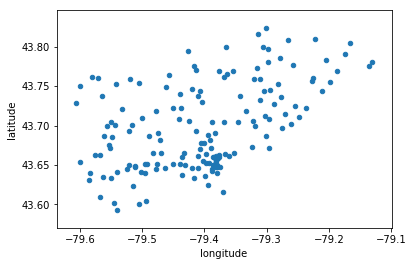

In [19]:
df.plot.scatter(x='longitude', y='latitude')
plt.show()

That looks alright. Finally, a small modification: Change column names for latitude and longitude to start with upper case L. For consistency.

In [20]:
df.rename(index=str, columns={"latitude":"Latitude", "longitude":"Longitude"}, inplace=True)

Now the DataFrame looks identical to the one from the exercise.

### Explore nearby venues and cluster neighborhoods

I'll do just the processing and ignore the intermediate steps. 

In [21]:
CLIENT_ID = 'HCGMUPDNQABJXJQE50D11NHYGURUPB1IUVDBLMICHHVQOCOW' # your Foursquare ID
CLIENT_SECRET = 'EY1AIW5QCE2HGFYKVR1WUOJ2MCTLIPJS3EMMD2UYMTABF2ZT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HCGMUPDNQABJXJQE50D11NHYGURUPB1IUVDBLMICHHVQOCOW
CLIENT_SECRET:EY1AIW5QCE2HGFYKVR1WUOJ2MCTLIPJS3EMMD2UYMTABF2ZT


In [22]:
LIMIT = 100 # No more than 100 results per query
radius = 500 # In a 500 metre radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Parkwoods
Victoria Village
Harbourfront
Regent Park
Lawrence Heights
Lawrence Manor
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Woodbine Heights
St. James Town
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
The Danforth West
Riverdale
Design Exchange
Toronto Dominion Centre
Brockton
Exhibition Place
Parkdale Village
Clairlea
Golden Mile
Oakridge
Silver H

,Neighborhood,Zoo,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,American Restaurant,Amphitheater,Animal Shelter,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.01,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.0,0.01,0.000000,0.0,0.000000,0.0,0.01,0.000000,0.0,0.0
1,Agincourt,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.090909,0.0,0.00,0.000000,0.0,0.0
2,Agincourt North,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.032258,0.0,0.032258,0.0,0.00,0.032258,0.0,0.0
3,Albion Gardens,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0
4,Alderwood,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0


In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Restaurant,Hotel,Italian Restaurant,Gastropub,Café,Gym,Seafood Restaurant,Breakfast Spot,Cosmetics Shop
1,Agincourt,Chinese Restaurant,Train Station,Korean Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Coffee Shop,Asian Restaurant,Rental Car Location,Cantonese Restaurant,Event Space
2,Agincourt North,Bakery,Ice Cream Shop,Chinese Restaurant,Bank,Liquor Store,Movie Theater,Sporting Goods Shop,Supermarket,Juice Bar,Taco Place
3,Albion Gardens,Hotel,Italian Restaurant,Bowling Alley,Hostel,Financial or Legal Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
4,Alderwood,Pizza Place,Pharmacy,Skating Rink,Gym,Coffee Shop,Pub,Sandwich Place,Pool,Dance Studio,Flea Market


### Cluster neighborhoods

In [26]:
from sklearn.cluster import KMeans

In [27]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# Let's see how many neighborhoods belong to each cluster
toronto_merged.groupby('Cluster Labels').count()

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0.0,117,117,117,117,117,117,117,117,117,117,117,117,117,117,117
1.0,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
2.0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4.0,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [50]:
toronto_merged.dropna(axis=0, how='any',inplace=True)
toronto_merged.reset_index(inplace=True, drop=True)
print("Number of rows after dropping NaNs:", len(toronto_merged) )
print("Number of NaNs:", toronto_merged.isna().sum() )

Number of rows after dropping NaNs: 165
Number of NaNs: Postcode                  0
Borough                   0
Neighborhood              0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64


### Create and populate map

In [35]:
import folium
from matplotlib import cm, colors

In [51]:
# create map
map_clusters = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

In [58]:
toronto_merged.groupby('Cluster Labels').count()

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0.0,117,117,117,117,117,117,117,117,117,117,117,117,117,117,117
1.0,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
2.0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4.0,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


### Cluster 0

In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,0.0,Chinese Restaurant,Pizza Place,Pharmacy,Video Store,Laundry Service,Convenience Store,Caribbean Restaurant,Discount Store,Bank,Shopping Mall
2,Downtown Toronto,0.0,Coffee Shop,Café,Hotel,Pizza Place,Italian Restaurant,Restaurant,Fried Chicken Joint,Sporting Goods Shop,Sports Bar,Steakhouse
3,Downtown Toronto,0.0,Coffee Shop,Thai Restaurant,Fast Food Restaurant,Animal Shelter,Grocery Store,Sushi Restaurant,Pub,Beer Store,Restaurant,Indian Restaurant
4,North York,0.0,Clothing Store,Coffee Shop,Sporting Goods Shop,American Restaurant,Cosmetics Shop,Fast Food Restaurant,Toy / Game Store,Bookstore,Food Court,Shopping Mall
6,Etobicoke,0.0,Hotel,Scenic Lookout,Park,Café,Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
9,North York,0.0,Restaurant,Coffee Shop,American Restaurant,Bar,Italian Restaurant,Mexican Restaurant,Electronics Store,Bakery,Bank,Middle Eastern Restaurant
10,East York,0.0,Bakery,Coffee Shop,Home Service,Park,Filipino Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
12,Downtown Toronto,0.0,Coffee Shop,Clothing Store,Café,Middle Eastern Restaurant,Ramen Restaurant,Bubble Tea Shop,Sandwich Place,Italian Restaurant,Japanese Restaurant,Burger Joint
13,Downtown Toronto,0.0,Coffee Shop,Clothing Store,Café,Diner,Ramen Restaurant,Middle Eastern Restaurant,Bar,Movie Theater,Japanese Restaurant,Thai Restaurant
15,Etobicoke,0.0,Pizza Place,Fast Food Restaurant,Coffee Shop,Pet Store,Discount Store,Supermarket,Furniture / Home Store,Clothing Store,Beer Store,Restaurant


### Cluster 1

In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1.0,Spa,Middle Eastern Restaurant,Asian Restaurant,Thai Restaurant,Food Court,Fast Food Restaurant,Event Space,Exhibit,Food Truck,Falafel Restaurant
5,North York,1.0,Bank,Electronics Store,Kids Store,Park,Yoga Studio,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market
8,Scarborough,1.0,Pizza Place,Pharmacy,Grocery Store,Fast Food Restaurant,Convenience Store,Bubble Tea Shop,Sandwich Place,Park,Ethiopian Restaurant,Event Space
14,North York,1.0,Playground,Pub,Tennis Court,Japanese Restaurant,Grocery Store,Deli / Bodega,Elementary School,Ethiopian Restaurant,Event Space,Exhibit
20,Scarborough,1.0,Train Station,Bus Line,Yoga Studio,Financial or Legal Service,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
23,East York,1.0,Skating Rink,Pharmacy,Athletics & Sports,Park,Bus Stop,Dance Studio,Cosmetics Shop,Flea Market,Flower Shop,Fish Market
25,Etobicoke,1.0,Convenience Store,Sandwich Place,Deli / Bodega,Shipping Store,Coffee Shop,Intersection,Donut Shop,Fast Food Restaurant,Event Space,Exhibit
27,Etobicoke,1.0,Golf Course,Baseball Field,Piano Bar,Park,Yoga Studio,Filipino Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market
28,Etobicoke,1.0,Dog Run,Flower Shop,Park,Yoga Studio,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
29,Scarborough,1.0,Train Station,Baseball Field,Storage Facility,Yoga Studio,Financial or Legal Service,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


### Cluster 2

In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,East York,2.0,Construction & Landscaping,Yoga Studio,Financial or Legal Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
133,Scarborough,2.0,Playground,Yoga Studio,Financial or Legal Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
162,Etobicoke,2.0,Playground,Poutine Place,Art Gallery,Construction & Landscaping,Gym / Fitness Center,Deli / Bodega,Department Store,Ethiopian Restaurant,Event Space,Exhibit


### Cluster 3

In [55]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,North York,3.0,Optical Shop,Financial or Legal Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


### Cluster 4

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Scarborough,4.0,Park,Fast Food Restaurant,Yoga Studio,Empanada Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Filipino Restaurant
21,Scarborough,4.0,Park,Yoga Studio,Empanada Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
26,Etobicoke,4.0,Park,Yoga Studio,Empanada Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
53,North York,4.0,Park,Baseball Field,Yoga Studio,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
93,Scarborough,4.0,Park,Gym Pool,Gym,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
106,Etobicoke,4.0,Pizza Place,Park,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
113,Etobicoke,4.0,Park,Yoga Studio,Empanada Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
122,Scarborough,4.0,Park,North Indian Restaurant,Caribbean Restaurant,Convenience Store,Filipino Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market
156,Etobicoke,4.0,Park,Spa,Metro Station,American Restaurant,Financial or Legal Service,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
